In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import random
import math
import pickle
from tqdm.notebook import tqdm_notebook
import sys
import scipy
from scipy.optimize import curve_fit
import torch
import torch.nn as nn
import torch.nn.functional as F
sys.path.append('../')
import fn

In [3]:
%load_ext autoreload
%autoreload 2

## Testing results locally

In [23]:
import addition_data
import addition_eval
from LSTM import LSTM
import time

In [6]:
with open('../pickles/carry_tables/all_tables_d1.pickle', 'rb') as f:
    all_tables = pickle.load(f)

In [65]:
b = 3
tables = all_tables[b]

In [66]:
table = tables[((0, 0, 0),
                (0, 0, 0),
                (0, 0, 0))]

In [67]:
model = LSTM(b, 1)

In [ ]:
losses, training_accs, testing_accs = addition_eval.eval(model, training_dataloader, testing_dataloader, num_passes=1000, print_loss_and_acc=True)

## Results from jobs

In [1463]:
with open('../pickles/learning_metrics/learning_metrics3.pickle', 'rb') as f:
    learning_metrics = pickle.load(f)

Text(0, 0.5, 'Accuracy')

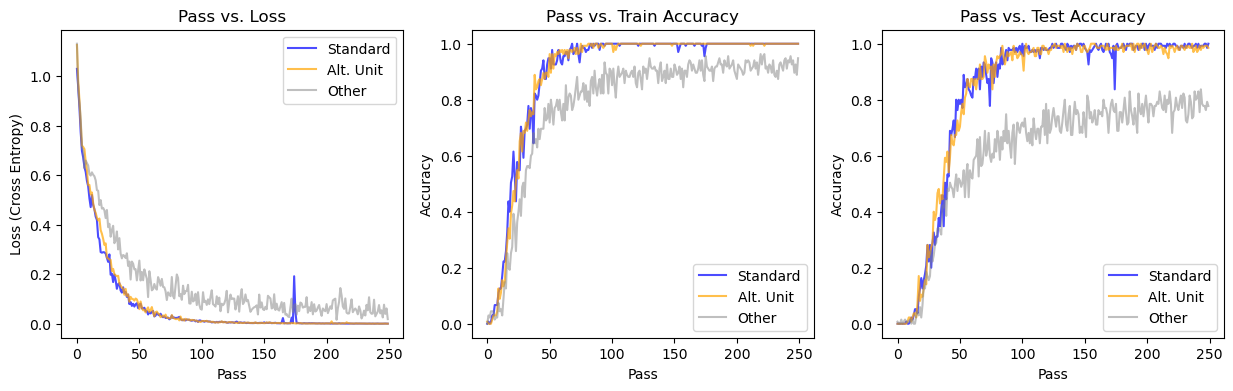

In [1464]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
for dc in learning_metrics.keys():
    loss = learning_metrics[dc]['loss']
    if (np.array(dc) == 0).all():
        ax.plot(loss, color='blue', alpha=0.7, label='Standard')
    elif len(np.unique(all_tables[3][dc])) == 2:
        ax.plot(loss, color='orange', alpha=0.7, label='Alt. Unit')
    else:
        ax.plot(loss, color='grey', alpha=0.5, label='Other')
ax.legend(labels=['Standard', 'Alt. Unit', 'Other'])
# ax.set_xlim((np.linspace(0, 250, 6), np.linspace(0, 2500, 6)))
ax.set_title(f'Pass vs. Loss')
ax.set_xlabel('Pass')
ax.set_ylabel('Loss (Cross Entropy)')

ax = axes[1]
for dc in learning_metrics.keys():
    train_acc = learning_metrics[dc]['training_acc']
    if (np.array(dc) == 0).all():
        ax.plot(train_acc, color='blue', alpha=0.7, label='Standard')
    elif len(np.unique(all_tables[3][dc])) == 2:
        ax.plot(train_acc, color='orange', alpha=0.7, label='Alt. Unit')
    else:
        ax.plot(train_acc, color='grey', alpha=0.5, label='Other')
ax.legend(labels=['Standard', 'Alt. Unit', 'Other'])
# ax.set_xlim((np.linspace(0, 250, 6), np.linspace(0, 2500, 6)))
ax.set_title(f'Pass vs. Train Accuracy')
ax.set_xlabel('Pass')
ax.set_ylabel('Accuracy')

ax = axes[2]
for dc in learning_metrics.keys():
    test_acc = learning_metrics[dc]['testing_acc']
    if (np.array(dc) == 0).all():
        ax.plot(test_acc, color='blue', alpha=0.7, label='Standard')
    elif len(np.unique(all_tables[3][dc])) == 2:
        ax.plot(test_acc, color='orange', alpha=0.7, label='Alt. Unit')
    else:
        ax.plot(test_acc, color='grey', alpha=0.5, label='Other')
ax.legend(labels=['Standard', 'Alt. Unit', 'Other'])
# ax.set_xlim(np.arange(250), np.linspace(0, 2490, 250))
ax.set_title(f'Pass vs. Test Accuracy')
ax.set_xlabel('Pass')
ax.set_ylabel('Accuracy')

## Correlate with box-counting dimension

In [1370]:
with open('../pickles/carry_tables/all_tables_d1.pickle', 'rb') as f:
    all_tables = pickle.load(f)

In [1371]:
with open('../pickles/est_dim_box_vs_depth.pickle', 'rb') as f:
    est_dim_box_vs_depth = pickle.load(f)

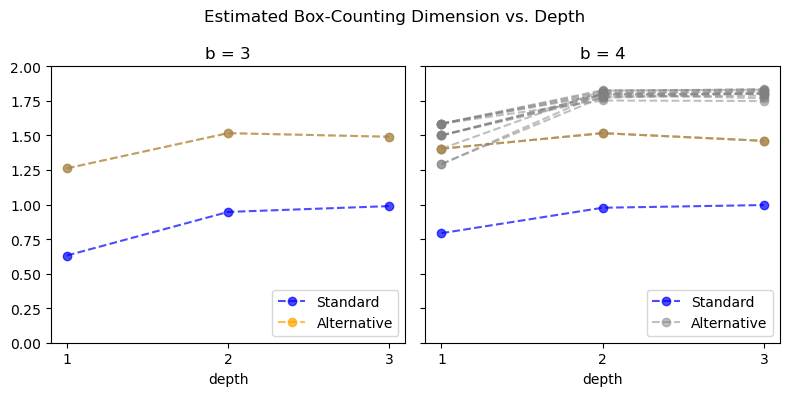

In [1372]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
for i in range(len(axes)):
    ax = axes[i]
    tables = all_tables[i+3]
    for dc in tables.keys():
        if (np.array(dc) == 0).all():
            ax.plot(est_dim_box_vs_depth[i+3][dc], color='blue', alpha=0.7, marker='o', linestyle='--', label='Standard')
        elif len(np.unique(tables[dc])) == 2:
            ax.plot(est_dim_box_vs_depth[i+3][dc], color='orange', alpha=0.7, marker='o', linestyle='--', label='Alt. Unit')
        else:
            ax.plot(est_dim_box_vs_depth[i+3][dc], color='grey', alpha=0.5, marker='o', linestyle='--', label='Other')
        ax.set_xticks([0, 1, 2], [1, 2, 3])
        ax.set_xlabel('depth')
        ax.set_yticks(np.linspace(0, 2, 9))
    if (i == 3):
        ax.set_ylabel('est. box-counting dim.')
    ax.set_title('b = '+str(i+3))
    ax.legend(labels=['Standard', 'Alternative'], loc='lower right')
fig.suptitle('Estimated Box-Counting Dimension vs. Depth')
plt.tight_layout()

In [1373]:
def acc(x, a, b, c):
    return a / (1 + np.exp(-b * (x - c)))

In [1375]:
x = np.arange(250)
dc = ((0,) * 3,) * 3
y = learning_metrics[dc]['testing_acc']
(a, b, c), cov = curve_fit(acc, x, y)

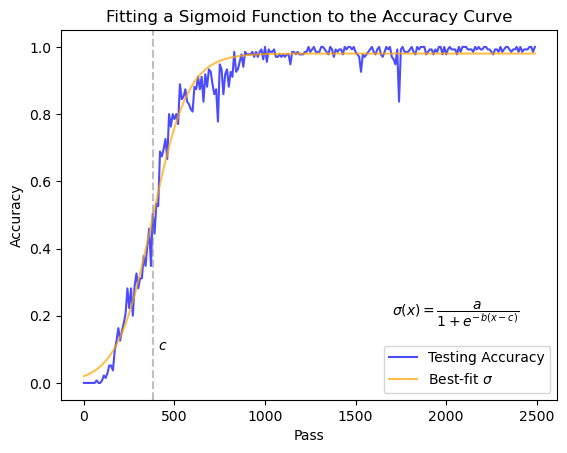

In [1435]:
plt.plot(y, color='blue', alpha=0.7, label='Testing Accuracy')
plt.plot(acc(x, a, b, c), color='orange', alpha=0.7, label=r'Best-fit $\sigma$')
plt.axvline(c, color='grey', alpha=0.5, linestyle='--')
plt.text(c+3, 0.1, '$c$')
plt.text(170, 0.2, r'$\sigma(x) = \dfrac{a}{1+e^{-b(x-c)}}$')
plt.legend()
plt.xticks(np.linspace(0, 250, 6), np.linspace(0, 2500, 6).astype('int'))
plt.xlabel('Pass')
plt.ylabel('Accuracy')
plt.title('Fitting a Sigmoid Function to the Accuracy Curve')
plt.show()

In [1328]:
all_est_dims = []
all_critical_pts = []

for b in range(3, 5):
    x = np.arange(250)
    with open(f'../pickles/learning_metrics/learning_metrics{b}.pickle', 'rb') as f:
        learning_metrics = pickle.load(f)
    est_dims = [est_dim_box_vs_depth[b][dc][2] for dc in all_tables[b].keys()]
    critical_pts = []
    for dc in all_tables[b].keys():
        y = learning_metrics[dc]['testing_acc']
        (a, b, c), cov = curve_fit(acc, x, y)
        critical_pts.append(c)
    all_est_dims += est_dims
    all_critical_pts += critical_pts

Text(0, 0.5, 'critical point of sigmoid fit')

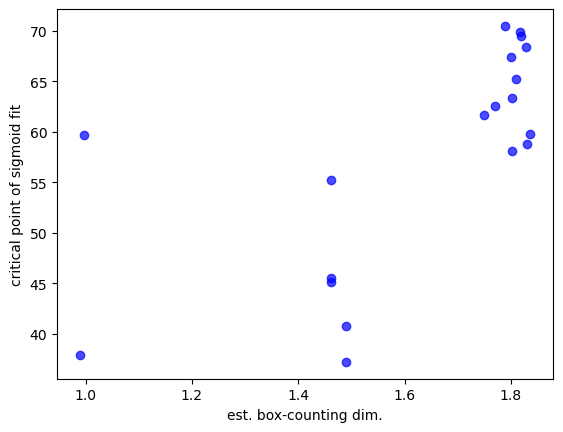

In [1436]:
plt.scatter(all_est_dims, all_critical_pts, color='blue', alpha=0.7)
# plt.xticks(np.linspace(0, 2, 9))
# plt.yticks(np.linspace(0, 250, 6))
plt.xlabel('est. box-counting dim.')
plt.ylabel('critical point of sigmoid fit')

In [1330]:
scipy.stats.spearmanr(all_est_dims, all_critical_pts)

SignificanceResult(statistic=0.6118696096373591, pvalue=0.005366848044010276)

## Test stability of learning rates

In [159]:
import addition_data
import addition_eval
from LSTM import LSTM

In [160]:
b = 3
tables = all_tables[b]

In [161]:
table = tables[((0, 0, 0),
                (0, 0, 0),
                (0, 0, 0))]

In [164]:
test_stable = {}
for i in tqdm_notebook(range(5)):
    model = LSTM(b, 1)
    training_dataloader, testing_dataloader = addition_data.prepare(b, 6, table, batch_size=64, split_type='OOD', split_depth=3, sample=True)
    losses, training_accs, testing_accs = addition_eval.eval(model, training_dataloader, testing_dataloader, num_passes=1000, print_loss_and_acc=False)
    metrics = {'loss': losses, 'training_acc': training_accs, 'testing_acc': testing_accs}
    test_stable[i] = metrics

  0%|          | 0/5 [00:00<?, ?it/s]

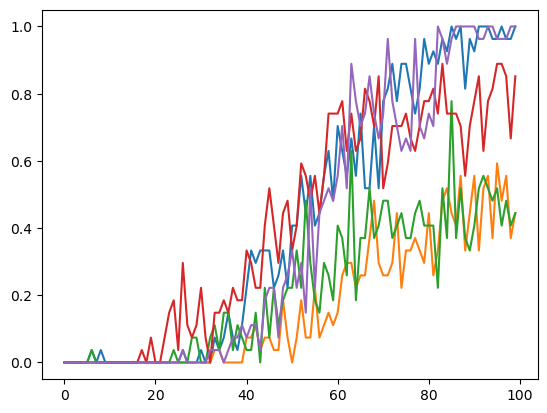

In [171]:
for i in test_stable.keys():
    plt.plot(test_stable[i]['testing_acc'])